# MP3 Robust Estimation and Geometric Vision

### Jiaxi Nie (nie9)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import ProjectiveTransform, warp
from harris import harris
from scipy.spatial import distance
import cv2
import random
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D


## Part 1 Stitching Pairs of Images

In [2]:
def find_matched_kp(grayimg1, grayimg2, flag_plot):
    """
    Find coordinates of putative matches from SIFT
    """
    '''
    # Harris Detector
    keypoints1 = harris(filename1)
    keypoints2 = harris(filename2)
    '''
    
    # find SIFT keypoints
    sift = cv2.xfeatures2d.SIFT_create()
    kp1 = sift.detect(grayimg1, None)    # len = 5345
    kp2 = sift.detect(grayimg2, None)    # len = 4280

    # build SIFT descriptor
    kp1, descriptor1 = sift.compute(grayimg1, kp1)
    kp2, descriptor2 = sift.compute(grayimg2, kp2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    if flag_plot:
        kp_img1 = cv2.drawKeypoints(grayimg1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(kp_img1)
        plt.show()
        kp_img2 = cv2.drawKeypoints(grayimg2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(kp_img2)
        plt.show()

    # find putative matches with the smallest distance
    descriptor_dist = distance.cdist(descriptor1, descriptor2, 'sqeuclidean')
    match_idx = np.unravel_index(np.argsort(np.ndarray.flatten(descriptor_dist)), (len(kp1), len(kp2)))
    match_idx1 = match_idx[0][:NUM_MATCH]
    match_idx2 = match_idx[1][:NUM_MATCH]

    # find coordinates of matched keypoints
    match1, match2 = kp1[match_idx1], kp2[match_idx2]
    
    return match1, match2

#### Part 1.1 - 1.5

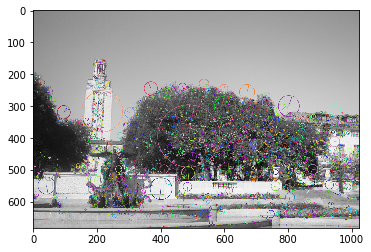

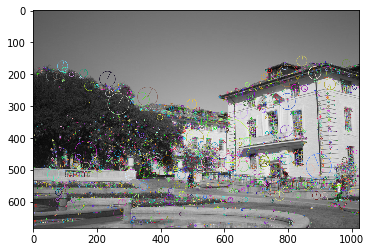

In [3]:
%matplotlib inline

filename1 = 'data/part1_data/uttower_left.JPG'
filename2 = 'data/part1_data/uttower_right.JPG'
orig_img1 = io.imread(filename1)
orig_img2 = io.imread(filename2)
grayimg1 = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2GRAY)
grayimg2 = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2GRAY)
img1 = color.rgb2gray(orig_img1).astype(np.double)
img2 = color.rgb2gray(orig_img2).astype(np.double)

# find coordinates of putative matches
NUM_MATCH = 40
match1, match2 = find_matched_kp(grayimg1, grayimg2, True)    
coord1 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match1]    #(x, y)
coord2 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match2]
coord1 = np.asarray(coord1)
coord2 = np.asarray(coord2)


In [4]:
def fit_homography(coord1, coord2):
    """
    Find homography matrix H and count inliers
    """
    init_pts_idx = np.arange(NUM_MATCH)
    np.random.shuffle(init_pts_idx)
    init_pts1 = coord1[init_pts_idx[:4]]    # (x, y)
    init_pts2 = coord2[init_pts_idx[:4]]
    # print(init_pts1)
    # print(init_pts2)

    # Build A in homography equation
    A = np.zeros((8, 9))
    for i in range(4):
        pt1, pt2 = init_pts1[i], init_pts2[i]
        xi = np.array([pt1[0], pt1[1], 1])
        y_xi = -pt2[1] * xi
        x_xi = -pt2[0] * xi
        A[2*i, 3:6] = xi
        A[2*i, 6:9] = y_xi
        A[2*i+1, 0:3] = xi
        A[2*i+1, 6:9] = x_xi
    # print(A)

    # Solve for homography matrix H
    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3,3)
    # print(H)

    # Find inliers
    unit_col = np.ones((NUM_MATCH, 1))
    xi_homo1 = np.concatenate((coord1, unit_col), axis = 1)
    xi_homo2 = np.concatenate((coord2, unit_col), axis = 1)
    cur_inliers = []
    num_inlier = 0

    # Calculate squared distance between transformed pairs
    for i in range(NUM_MATCH):
        xi = xi_homo1[i]
        res = np.matmul(H, xi)
        res /= res[-1]
        sqr_dist = np.linalg.norm(res - xi_homo2[i])
        if sqr_dist < INLIER_THRESHOLD:
            num_inlier += 1
            cur_inliers.append([xi, xi_homo2[i]])
    # print("num_inlier", num_inlier)
    return num_inlier, np.asarray(cur_inliers)


In [5]:
def draw_matched_inliers(max_inlier, best_inliers, orig_img1, orig_img2):
    """
    Draw lines between matched keypoints
    """
    # build matches
    matches = []
    inlier_kp1 = []
    inlier_kp2 = []
    for i in range(max_inlier):
        kp1 = cv2.KeyPoint()
        kp1.pt = (best_inliers[i][0][0], best_inliers[i][0][1])
        inlier_kp1.append(kp1)
        kp2 = cv2.KeyPoint()
        kp2.pt = (best_inliers[i][1][0], best_inliers[i][1][1])
        inlier_kp2.append(kp2)
        match = cv2.DMatch()
        match.imgIdx, match.queryIdx, match.trainIdx = i, i, i
        matches.append(match)
        
    # Draw lines
    # Reference: https://www.snip2code.com/Snippet/443281/Python-replacement-for-cv2-drawMatches()
    if len(orig_img1.shape) == 3:
        new_shape = (max(orig_img1.shape[0], orig_img2.shape[0]), orig_img1.shape[1]+orig_img2.shape[1], orig_img1.shape[2])
    elif len(orig_img1.shape) == 2:
        new_shape = (max(orig_img1.shape[0], orig_img2.shape[0]), orig_img1.shape[1]+orig_img2.shape[1])
    new_img = np.zeros(new_shape, type(orig_img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:orig_img1.shape[0],0:orig_img1.shape[1]] = orig_img1
    new_img[0:orig_img2.shape[0],orig_img1.shape[1]:orig_img1.shape[1]+orig_img2.shape[1]] = orig_img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 10
    thickness = 2
    c = (0, 255, 0)
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(orig_img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(inlier_kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(inlier_kp2[m.queryIdx].pt).astype(int) + np.array([orig_img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.title('Matched Inliers')
    plt.savefig('result/part1_matched_inliers.jpg')
    plt.show()
    return

In [6]:
def RANSAC(coord1, coord2, orig_img1, orig_img2, flag_draw=True):
    max_inlier = 0
    
    # Find the homography transform with the most inliers
    for n in range(NUM_ITER):
        #print("iter ", n)
        num_inlier, cur_inliers = fit_homography(coord1, coord2)
        if num_inlier > max_inlier:
            max_inlier = num_inlier
            best_inliers = cur_inliers
    print("max_inliers =", max_inlier)
    
    # Draw matched inliers
    if flag_draw:
        draw_matched_inliers(max_inlier, best_inliers, orig_img1, orig_img2)
    
    # Refit H using inliers
    A = np.zeros((2*max_inlier, 9))
    for i in range(max_inlier):
        xi1, xi2 = best_inliers[i][0], best_inliers[i][1]
        y_xi = -xi2[1] * xi1
        x_xi = -xi2[0] * xi1
        A[2*i, 3:6] = xi1
        A[2*i, 6:9] = y_xi
        A[2*i+1, 0:3] = xi1
        A[2*i+1, 6:9] = x_xi
    U, s, V = np.linalg.svd(A)
    refit_H = V[len(V)-1].reshape(3,3)
    
    # Calculate residual (squared distance of inliers)
    residual = 0
    for i in range(max_inlier):
        xi1 = best_inliers[i][0]
        xi1_trans = np.matmul(refit_H, xi1)
        xi2 = best_inliers[i][1]
        xi1_trans /= xi1_trans[-1]
        residual += np.linalg.norm(xi2 - xi1_trans)
    residual /= max_inlier
    print("average residual of inlier =", residual)
    return refit_H
            

In [9]:
def warpTwoImages(img1, img2, H):
    """
    warp img2 to img1 with homograph H
    Reference: https://stackoverflow.com/questions/13063201/how-to-show-the-
               whole-image-when-using-opencv-warpperspective
    """
    grayscale = len(img1.shape) == 2
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]    # t = (x,y) = (643, 185), top-left coord of img2
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]]) # translate
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))    # (h, w)
    
    # Average overlapping area
    if grayscale:
        for y in range(h1):
            for x in range(w1):
                if t[0]+x < result.shape[1] and t[1]+y < result.shape[0]:
                    if result[t[1]+y, t[0]+x] == 0:
                        result[t[1]+y, t[0]+x] = img1[y, x]
                    else:
                        result[t[1]+y, t[0]+x] = result[t[1]+y, t[0]+x] / 2 + img1[y, x] / 2
    else:
        for y in range(h1):
            for x in range(w1):
                if t[0]+x < result.shape[1] and t[1]+y < result.shape[0]:
                    if np.count_nonzero(result[t[1]+y, t[0]+x]) == 0:
                        result[t[1]+y, t[0]+x, :] = img1[y, x, :]
                    else:
                        result[t[1]+y, t[0]+x, 0] = result[t[1]+y, t[0]+x, 0] / 2 + img1[y, x, 0] / 2
                        result[t[1]+y, t[0]+x, 1] = result[t[1]+y, t[0]+x, 1] / 2 + img1[y, x, 1] / 2
                        result[t[1]+y, t[0]+x, 2] = result[t[1]+y, t[0]+x, 2] / 2 + img1[y, x, 2] / 2

    return result

#### Part 1.6 - 1.8

max_inliers = 40


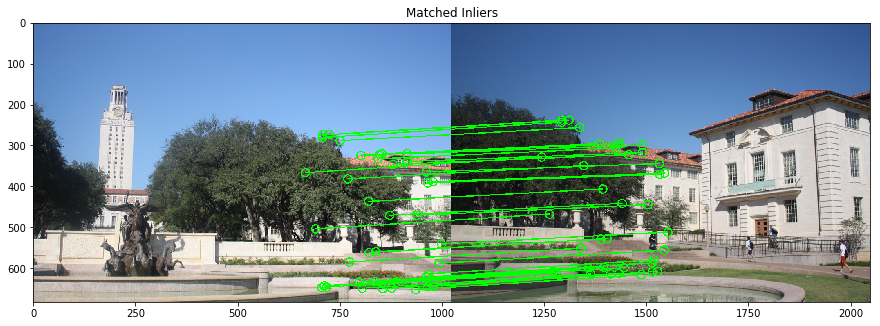

average residual of inlier = 0.5930788628662722


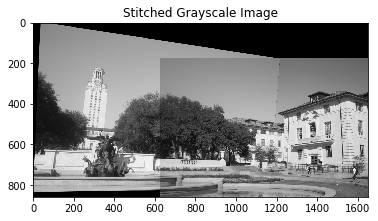

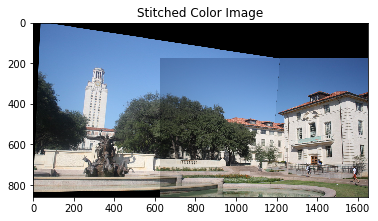

In [10]:
NUM_ITER = 10
INLIER_THRESHOLD = 2
H = RANSAC(coord1, coord2, orig_img1, orig_img2, True)

stitched_grayimg = warpTwoImages(grayimg2, grayimg1, H)
plt.imshow(stitched_grayimg, cmap='gray')
plt.title('Stitched Grayscale Image')
plt.savefig('result/part1_stitched_grayimg.jpg')
plt.show()
stitched_img = warpTwoImages(orig_img2, orig_img1, H)
plt.imshow(stitched_img)
plt.title('Stitched Color Image')
plt.savefig('result/part1_stitched_colorimg.jpg')
plt.show()
#print(stitched_img.shape)

#### extra credit

In [15]:
def threefold_stitch(obj):
    """
    Perform threefold stitching to form a large panorama
    """
    filename1 = 'data/part1_extra_data/' + obj + '/1.JPG'
    filename2 = 'data/part1_extra_data/' + obj + '/2.JPG'
    filename3 = 'data/part1_extra_data/' + obj + '/3.JPG'
    orig_img1 = io.imread(filename1)
    orig_img2 = io.imread(filename2)
    orig_img3 = io.imread(filename3)
    grayimg1 = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2GRAY)
    grayimg2 = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2GRAY)
    grayimg3 = cv2.cvtColor(orig_img3, cv2.COLOR_BGR2GRAY)
    img1 = color.rgb2gray(orig_img1).astype(np.double)
    img2 = color.rgb2gray(orig_img2).astype(np.double)
    img3 = color.rgb2gray(orig_img3).astype(np.double)

    # find coordinates of putative matches
    NUM_MATCH = 40
    match1, match2 = find_matched_kp(grayimg1, grayimg2, False)    
    coord1 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match1]    #(x, y)
    coord2 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match2]
    coord1 = np.asarray(coord1)
    coord2 = np.asarray(coord2)

    NUM_ITER = 10
    INLIER_THRESHOLD = 2
    H = RANSAC(coord1, coord2, orig_img1, orig_img2, False)

    # stitched first two images
    stitched_grayimg = warpTwoImages(grayimg2, grayimg1, H)
    stitched_img = warpTwoImages(orig_img2, orig_img1, H)

    # stitch the result with the third image
    match3, match4 = find_matched_kp(stitched_grayimg, grayimg3, False)    
    coord3 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match3]    #(x, y)
    coord4 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match4]
    coord3 = np.asarray(coord3)
    coord4 = np.asarray(coord4)

    H2 = RANSAC(coord3, coord4, stitched_img, orig_img3, False)

    stitched_grayimg2 = warpTwoImages(grayimg3, stitched_grayimg, H2)
    plt.imshow(stitched_grayimg2, cmap='gray')
    title = 'Stitched Grayscale Image of ' + obj 
    plt.title(title)
    out_path = 'result/part1_extra_stitched_gray_' + obj + '.jpg'
    plt.savefig(out_path)
    plt.show()
    stitched_img2 = warpTwoImages(orig_img3, stitched_img, H2)
    plt.imshow(stitched_img2)
    title = 'Stitched Color Image of ' + obj
    plt.title(title)
    out_path = 'result/part1_extra_stitched_color_' + obj + '.jpg'
    plt.savefig(out_path)
    plt.show()
    #print(stitched_img.shape)
    
    return

pier
max_inliers = 37
average residual of inlier = 0.35929280321485946
max_inliers = 40
average residual of inlier = 0.36635067873989885


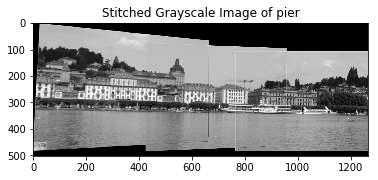

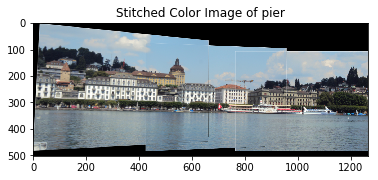

hill
max_inliers = 40
average residual of inlier = 0.46972130818526486
max_inliers = 36
average residual of inlier = 0.509654292034097


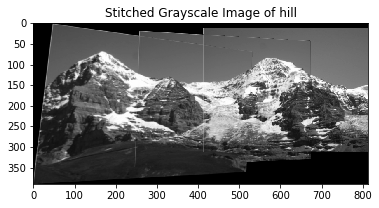

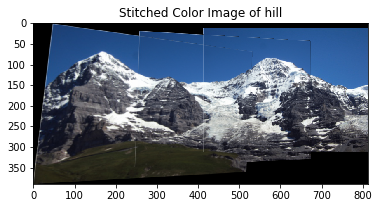

ledge
max_inliers = 36
average residual of inlier = 0.4623791330984526
max_inliers = 32
average residual of inlier = 0.5735557779809491


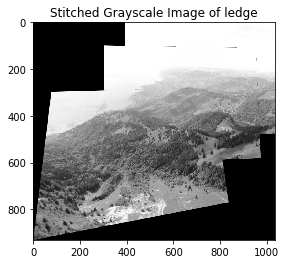

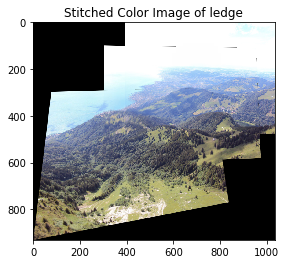

In [16]:
img_list = ['pier', 'hill', 'ledge']
for fn in img_list:
    print(fn)
    threefold_stitch(fn)
    

## Part 2 Fundamental Matrix Estimation and Triangulation

In [3]:
def visualize(img1, img2, matches):
    h1, w1 = img1.shape[0], img1.shape[1]
    h, w = h1, w1*2
    full_img = np.zeros((h, w, 3))
    full_img[:, :w1, :] = img1;
    full_img[:, w1:, :] = img2;
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(full_img).astype(np.uint8))
    ax.plot(matches[:, 0], matches[:, 1],  '+r')
    ax.plot(matches[:, 2]+w1, matches[:, 3], '+r')
    ax.plot([matches[:, 0], matches[:, 2]+w1], [matches[:, 1], matches[:, 3]], 'r')
    plt.title('Matched Keypoints')
    plt.show()
    return


In [4]:
def normalize(matches):
    """
    normalize coordinates of matched points
    """
    num_match = matches.shape[0]
    matches_mean = matches - np.mean(matches, axis=0)
    # scale to have mean squared distance of 2 for each column
    
    scale1 = np.sqrt(2*num_match / np.sum(np.square(matches_mean[:, :2])))
    scale2 = np.sqrt(2*num_match / np.sum(np.square(matches_mean[:, 2:])))
    
    matches_scaled1 = scale1 * matches_mean[:, :2]
    matches_scaled2 = scale2 * matches_mean[:, 2:]
    matches_scaled = np.concatenate((matches_scaled1, matches_scaled2), axis=1)
    
    T1, T2 = np.zeros((3,3)), np.zeros((3,3))
    T1[0, 0], T1[1, 1] = scale1, scale1
    T1[0, 2] = -scale1 * np.mean(matches[:, 0])
    T1[1, 2] = -scale1 * np.mean(matches[:, 1])
    T2[0, 0], T2[1, 1] = scale2, scale2
    T2[0, 2] = -scale2 * np.mean(matches[:, 2])
    T2[1, 2] = -scale2 * np.mean(matches[:, 3])
    T1[2, 2], T2[2, 2] = 1, 1
    
    return T1, T2, matches_scaled
    

In [5]:
def fit_fundamental(matches, flag_normalized):
    """
    Find fundamental matrix F by solving homogeneous linear 
    system matched pts
    """
    if flag_normalized:
        T1, T2, matches = normalize(matches)
    
    num_match = matches.shape[0]
    A = np.ones((num_match, 9))
    for i in range(num_match):
        u1, v1, u2, v2 = matches[i][:]
        A[i, 0] = u1 * u2
        A[i, 1] = v1 * u2
        A[i, 2] = u2
        A[i, 3] = u1 * v2
        A[i, 4] = v1 * v2
        A[i, 5] = v2
        A[i, 6] = u1
        A[i, 7] = v1
    
    _, _, V = np.linalg.svd(A)
    F = V[len(V)-1].reshape(3,3)
    U, s, V = np.linalg.svd(F)
    s[-1] = 0
    s_new = s * np.identity(3)
    F_new = np.matmul(np.matmul(U, s_new), V)
    
    if flag_normalized:
        F_new = np.matmul(np.matmul(T2.T, F_new), T1)

    return F_new

In [6]:
def project_epipolar(I2, matches, flag_normalized, filename):
    """
    Display second image with epipolar lines reprojected from the first image
    """
    num_matches = matches.shape[0]
    # first, fit fundamental matrix to the matches
    F = fit_fundamental(matches, flag_normalized); 
    M = np.c_[matches[:,0:2], np.ones((num_matches,1))].transpose()

    # transform points from the first image to get epipolar lines in the second image
    L1 = np.matmul(F, M).transpose() 

    # find points on epipolar lines L closest to matches(:, 3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())    # rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((num_matches,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10   # offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(np.uint8))
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    title = 'Normalized' if flag_normalized else 'Unnormalized'
    path = 'result/part2_' + filename + '_' + title + '.jpg'
    plt.title(title)
    plt.savefig(path)
    plt.show()
    
    residual = np.mean(np.abs(pt_line_dist))
    print('residual =', residual)
    return
    

In [7]:
def RANSAC2(all_matches, img2, filename):
    """
    RANSAC to select inliers
    """
    max_inlier = 0
    num_matches = all_matches.shape[0]
    # Find the fundamental matrix with the most inliers
    for n in range(NUM_ITER):
        #print("iter ", n)
        init_pts_idx = np.arange(num_matches)
        np.random.shuffle(init_pts_idx)
        matches = all_matches[init_pts_idx[:8]]    # (x, y)
        F  = fit_fundamental(matches, True); 
        M = np.c_[all_matches[:,0:2], np.ones((num_matches, 1))].transpose()

        # transform points from the first image to get epipolar lines in the second image
        L1 = np.matmul(F, M).transpose() 
        
        # find points on epipolar lines L closest to matches(:, 3:4)
        l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
        L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())    # rescale the line
        pt_line_dist = np.multiply(L, np.c_[all_matches[:,2:4], np.ones((num_matches,1))]).sum(axis = 1)
        
        # Find inliers
        cur_inliers = []
        num_inlier = 0
        for i in range(num_matches):
            if pt_line_dist[i] < INLIER_THRESHOLD:
                num_inlier += 1
                cur_inliers.append(all_matches[i])

        if num_inlier > max_inlier:
            max_inlier = num_inlier
            best_inliers = np.asarray(cur_inliers)
    print("max_inliers =", max_inlier)
    
    project_epipolar(img2, best_inliers, False, filename)
    return
    

In [8]:
def triangulate(P1, P2, matches):
    """
    Perform linear triangulation
    """
    num_match = matches.shape[0]
    kp1 = np.concatenate((matches[:, :2], np.ones((num_match, 1))), axis=1)
    kp2 = np.concatenate((matches[:, 2:], np.ones((num_match, 1))), axis=1)
    
    # Reconstruct 3D coordinates
    X = np.zeros((num_match, 4))
    for i in range(num_match):
        xi1 = np.array([[0, -kp1[i, 2], kp1[i, 1]],
                        [kp1[i, 2], 0, -kp1[i, 0]],
                        [-kp1[i, 1], kp1[i, 0], 0]])
        xi2 = np.array([[0, -kp2[i, 2], kp2[i, 1]],
                        [kp2[i, 2], 0, -kp2[i, 0]],
                        [-kp2[i, 1], kp2[i, 0], 0]])  
        
        A1 = np.matmul(xi1, P1)
        A2 = np.matmul(xi2, P2)
        A = np.vstack((A1, A2))

        _, _, V = np.linalg.svd(A)
        temp = V[len(V)-1]
        X[i] = temp / temp[-1]
    
    return X
    

In [9]:
def plot_3D(P1, P2, X, filename, init1, init2):
    # Find camera centers
    U, s, V = np.linalg.svd(P1)
    center1 = V[len(V)-1]
    center1 /= center1[-1]
    U, s, V = np.linalg.svd(P2)
    center2 = V[len(V)-1]
    center2 /= center2[-1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(init1, init2)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    ax.scatter(center1[0], center1[1], center1[2], '+r')
    ax.scatter(center2[0], center2[1], center2[2], '+g')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.title(filename)
    out_path = 'result/part2_' + filename + '_' + str(init1) + '_' + str(init2) + '.jpg'
    plt.savefig(out_path)
    plt.show()
    

In [10]:
def calc_residual(P1, P2, X, matches):
    """
    Calculate the residual of 3D points projected back onto 2D space
    """
    num_match = matches.shape[0]
    residual = 0
    for i in range(num_match):
        x1 = np.matmul(P1, X[i])
        x1 /= x1[-1]
        x2 = np.matmul(P2, X[i])
        x2 /= x2[-1]
        residual += np.linalg.norm(x1-np.concatenate((matches[i, :2], np.ones((1))))) 
        residual += np.linalg.norm(x2-np.concatenate((matches[i, 2:], np.ones((1))))) 
    residual /= (2 * num_match)
    print('residual =', residual)
    return 
    

In [11]:
def part_2(filename, filename1, filename2, matches, P1, P2):
    """
    Code for part 2
    """
    # Part 2.1
    img1 = io.imread(filename1)    # (h, w)
    img2 = io.imread(filename2)
    grayimg1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayimg2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    num_match = len(matches)
    visualize(img1, img2, matches)

    # Part 2.2
    # Find fundamental matrix and draw epipolar lines
    project_epipolar(img2, matches, False, filename)
    project_epipolar(img2, matches, True, filename)
    
    # Part 2.3
    match1, match2 = find_matched_kp(grayimg1, grayimg2, False)    
    coord1 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match1]    #(x, y)
    coord2 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match2]
    coord1 = np.asarray(coord1)
    coord2 = np.asarray(coord2)
    matches_sift = np.concatenate((coord1, coord2), axis=1)

    NUM_ITER = 10
    INLIER_THRESHOLD = 2
    filename_ransac = filename + '_RANSAC'
    RANSAC2(matches_sift, img2, filename_ransac)

    # Part 2.4
    X = triangulate(P1, P2, matches)    # (N, x, y, z)
    plot_3D(P1, P2, X, filename, 30, 50)
    plot_3D(P1, P2, X, filename, 20, 70)
    plot_3D(P1, P2, X, filename, 10, 90)
    calc_residual(P1, P2, X, matches)
    
    return

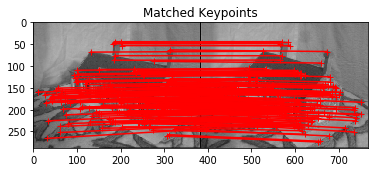

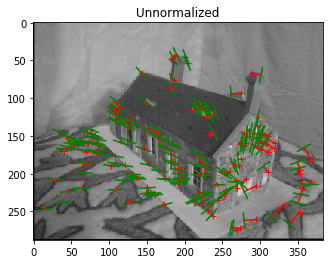

residual = 3.034173540660321


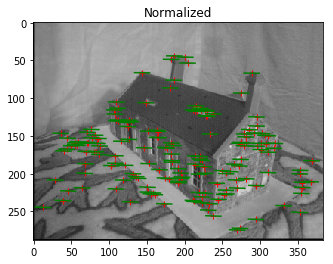

residual = 0.21027139632673764
max_inliers = 35


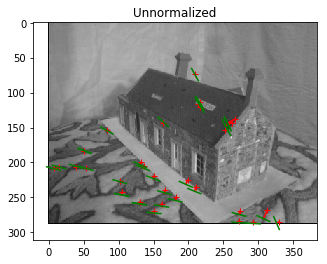

residual = 3.396896966075104


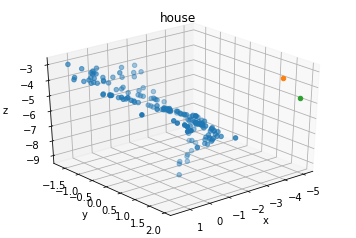

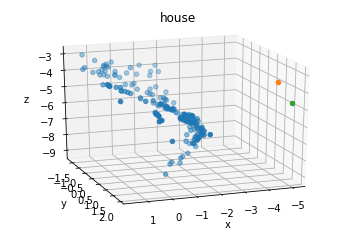

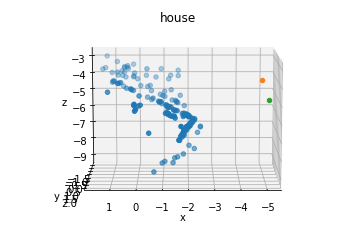

residual = 0.16929579986215756


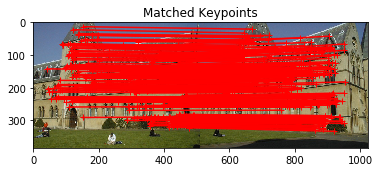

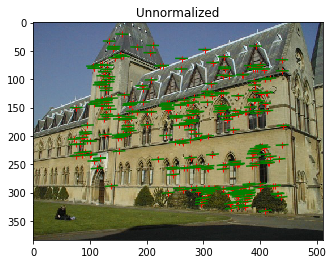

residual = 0.3384950960720165


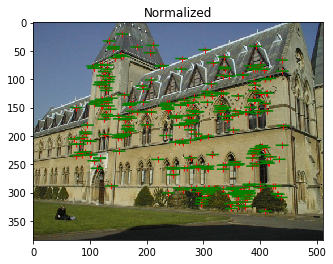

residual = 0.18359661716195497
max_inliers = 40


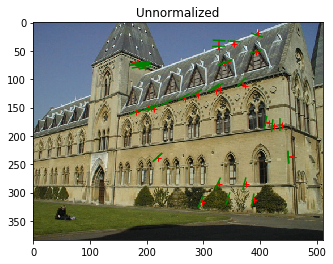

residual = 3.3712080354888565


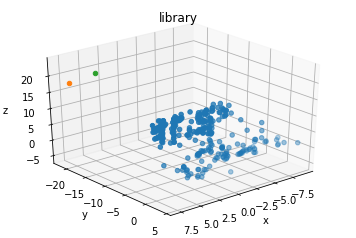

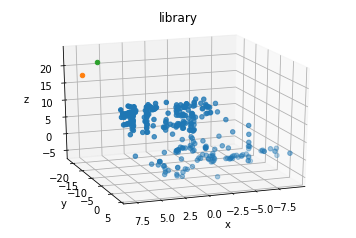

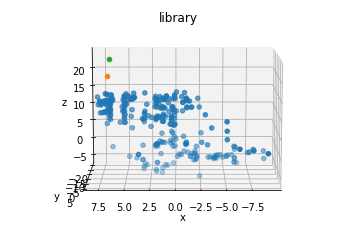

residual = 0.2149087258433689


In [21]:
NUM_MATCH = 40
NUM_ITER = 10
INLIER_THRESHOLD = 2

filename = 'house'
filename1 = 'data/part2_data/house1.jpg'
filename2 = 'data/part2_data/house2.jpg'
matches = np.loadtxt('data/part2_data/house_matches.txt')    # (168, 4)
P1 = np.loadtxt('data/part2_data/house1_camera.txt')    # Camera projection matrix: (3, 4)
P2 = np.loadtxt('data/part2_data/house2_camera.txt')
part_2(filename, filename1, filename2, matches, P1, P2)


filename = 'library'
filename1 = 'data/part2_data/library1.jpg'
filename2 = 'data/part2_data/library2.jpg'
matches = np.loadtxt('data/part2_data/library_matches.txt')
P1 = np.loadtxt('data/part2_data/library1_camera.txt')    # Camera projection matrix: (3, 4)
P2 = np.loadtxt('data/part2_data/library2_camera.txt')
part_2(filename, filename1, filename2, matches, P1, P2)


## Part 3 Single-View Geometry

### Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

### Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(im, lines, vp, idx):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.title('Vanishing Point')
    out_path = 'result/part3_vp_' + str(idx) + '.jpg'
    plt.savefig(out_path)
    plt.show()

In [4]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the 
    bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the 
            object and coord[:, 1] is the homogeneous coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')
    plt.title(obj)
    plt.savefig('result/part3_' + obj + '.jpg')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

In [5]:
def get_vanishing_point(lines):
    """
    Solves for the vanishing point using the user-input lines.
    inputs: lines: np.ndarray of shape (3, n)
    """
    # get intersection of input lines
    intersect1 = np.cross(lines[:, 0], lines[:, 1])
    intersect2 = np.cross(lines[:, 1], lines[:, 2])
    intersect3 = np.cross(lines[:, 0], lines[:, 2])
    # convert to homogeneous coordinate
    intersect1 /= intersect1[-1]
    intersect2 /= intersect2[-1]
    intersect3 /= intersect3[-1]
    
    intersections = np.vstack((intersect1, intersect2, intersect3))
    vp = np.mean(intersections, axis=0)
    print('vanishing point:', vp)
    return vp


In [14]:
def get_horizon_line(vpts):
    """
    Calculates the ground horizon line.
    """
    vx, vy = vpts[:, 0], vpts[:, 1]
    a, b, c = np.cross(vx, vy)
    scale = np.sqrt(1 / (a**2 + b**2))
    line = np.array([a, b, c]) * scale
    
    print('Horizon Line:', line)
    return line

In [7]:
def plot_horizon_line(img, vpts):
    """
    Plot the horizon line.
    """
    plt.figure()
    plt.imshow(img)
    pt1, pt2 = vpts[:, 0], vpts[:, 1]
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')
    plt.plot(pt1[0], pt1[1], 'ro')
    plt.plot(pt2[0], pt2[1], 'ro')
    plt.title('Horizon Line')
    plt.savefig('result/part3_horizon_line.jpg')
    plt.show()
    return

In [8]:
def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    pt1, pt2, pt3 = Matrix(vpts[:, 0]), Matrix(vpts[:, 1]), Matrix(vpts[:, 2])
    f, px, py = Symbol('f'), Symbol('px'), Symbol('py')
    K = Matrix( ((f, 0, px), (0, f, py), (0, 0, 1)) )
    K_inv = K.inv()
    Eq1 = pt1.T * K_inv.T * K_inv * pt2
    Eq2 = pt1.T * K_inv.T * K_inv * pt3
    Eq3 = pt2.T * K_inv.T * K_inv * pt3
    res = solve([Eq1, Eq2, Eq3], [f, px, py])
    print("Camera parameters", res[0])
    
    f, px, py = res[0]
    return f, px, py


In [9]:
def get_rotation_matrix(vpts, f, px, py):
    """
    Compute the rotation matrix using the camera parameters.
    """
    vpx, vpy, vpz = vpts[:, 1], vpts[:, 2], vpts[:, 0]
    K = np.array([[f, 0, px], [0, f, py], [0, 0, 1]]).astype(np.float)
    K_inv = np.linalg.inv(K)
    
    r1 = np.matmul(K_inv, vpx)
    r2 = np.matmul(K_inv, vpy)
    r3 = np.matmul(K_inv, vpz)
    
    R1 = 1 / np.linalg.norm(r1) * r1
    R2 = 1 / np.linalg.norm(r2) * r2
    R3 = 1 / np.linalg.norm(r3) * r3
    
    R = np.vstack((R1, R2, R3)).T
    print('Rotation Matrix:', R)
    return R

In [10]:
def estimate_height(coord_ref, coord_obj, vpts, H_ref):
    """
    Estimates height for a specific object using the recorded coordinates. You 
    might need to plot additional images here for your report.
    Input: coord (3, 2)
    """
    vpx, vpy, vpz = vpts[:, 0], vpts[:, 1], vpts[:, 2]
    r, b = coord_obj[:, 0], coord_obj[:, 1]
    t0, b0 = coord_ref[:, 0], coord_ref[:, 1]
    v = np.cross(np.cross(b, b0), np.cross(vpx, vpy))
    t = np.cross(np.cross(v, t0), np.cross(r, b))
    t /= t[-1]
    
    ratio = np.linalg.norm(t-b) * np.linalg.norm(vpz-r) / (np.linalg.norm(r-b) * np.linalg.norm(vpz-t))
    print('Image cross ratio =', '{:.2f}'.format(ratio))
    height = H_ref / ratio
    print('Height =', '{:.2f}'.format(height), 'm')
    return height


In [11]:
% matplotlib tk
import matplotlib.pyplot as plt
from sympy import Symbol, Matrix, solve
import numpy as np
from PIL import Image

In [15]:
im = np.asarray(Image.open('data/part3_data/CSL.jpg'))

# Part 3.1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
# line order: left, right, top
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)    # lines / centers = (3, n)
    # Solve for vanishing point
    vpts[:, i] = get_vanishing_point(lines)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(im, lines, vpts[:, i], i)

# Get the ground horizon line
horizon_line = get_horizon_line(vpts)
# Plot the ground horizon line
plot_horizon_line(im, vpts)


Getting vanishing point 0
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
vanishing point: [-189.99738693  222.92904168    1.        ]
Getting vanishing point 1
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
vanishing point: [1.36238896e+03 2.15804556e+02 1.00000000e+00]
Getting vanishi

In [24]:
# Part 3.2
# Solve for the camera parameters (f, u, v)
f, px, py = get_camera_parameters(vpts)

# Part 3.3
# Solve for the rotation matrix
R = get_rotation_matrix(vpts, f, px, py)

# Part 3.4
# Record image coordinates for each object and store in map
objects = ('person', 'CSL_building', 'the_spike_statue', 'the_lamp_posts', 
           'person2', 'person3', 'person4', 'window')
coords = dict()
for obj in objects:
    coords[obj] = get_top_and_bottom_coordinates(im, obj)

# Estimate heights: reference height (of the person) in cm: 167.64 / 182.88
R = 1.6764   
print("")
print("Reference height =", '{:.2f}'.format(R), 'm')
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(coords['person'], coords[obj], vpts, R)

R = 1.8288  
print("")
print("Reference height =", '{:.2f}'.format(R), 'm')
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(coords['person'], coords[obj], vpts, R)

Camera parameters (-774.248573259248, 582.599031144119, 319.656483477591)
Rotation Matrix: [[-0.70605419  0.00254037  0.70815325]
 [ 0.0787314  -0.99351255  0.08206207]
 [ 0.70376761  0.11369416  0.70127369]]
Click on the top coordinate of person
Click on the bottom coordinate of person
Click on the top coordinate of CSL_building
Click on the bottom coordinate of CSL_building
Click on the top coordinate of the_spike_statue
Click on the bottom coordinate of the_spike_statue
Click on the top coordinate of the_lamp_posts
Click on the bottom coordinate of the_lamp_posts
Click on the top coordinate of person2
Click on the bottom coordinate of person2
Click on the top coordinate of person3
Click on the bottom coordinate of person3
Click on the top coordinate of person4
Click on the bottom coordinate of person4
Click on the top coordinate of window
Click on the bottom coordinate of window

Reference height = 1.68 m
Estimating height of CSL_building
Image cross ratio = 0.05
Height = 32.44 m
Es

In [13]:
print(vpts)

[[-1.91587680e+02  1.37879697e+03  6.15227763e+01]
 [ 2.18875945e+02  2.28689345e+02 -2.47682289e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00]]
